# Spatial variation in continental vs. glacial river contributions 

In [1]:
import pickle
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import cmocean

%matplotlib inline

##### Parameters:

In [2]:
# Domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax - imin
jsize = jmax - jmin

# Results folders:
folder_ref  = '/data/brogalla/run_storage/Mn-reference-202110/'
folder_glac = '/data/brogalla/run_storage/river-glacial-202112/'
folder_cont = '/data/brogalla/run_storage/river-continental-202112/'
folder_seas = '/data/brogalla/run_storage/river-seasonal-202201/'

# Boundary coordinates:
xmin=imin+1; ymin=jmin+1;
r1i = 1520-xmin;                      r1j = np.arange(505-ymin,673-ymin)
N1i = np.arange(1570-xmin,1630-xmin); N1j = 635-ymin #Nares
P1i = 1585-xmin;                      P1j = np.arange(485-ymin,538-ymin)  #Parry channel
P1j = P1j[10:-5]; N1i = N1i[11:-8]

land_color = '#a9a7a2'

# Color map:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(171/N, 1, N)
vals_cont[:, 1] = np.linspace(92/N, 1, N)
vals_cont[:, 2] = np.linspace(41/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

vals_glac = np.ones((N, 4))
vals_glac[:, 0] = np.linspace(8/N, 1, N)
vals_glac[:, 1] = np.linspace(115/N, 1, N)
vals_glac[:, 2] = np.linspace(180/N, 1, N)
glac_cmap = ListedColormap(vals_glac).reversed()

vals_both = np.ones((N, 4))
vals_both[:, 0] = np.linspace(89/N, 1, N); 
vals_both[:, 1] = np.linspace(89/N, 1, N)
vals_both[:, 2] = np.linspace(89/N, 1, N)
both_cmap = ListedColormap(vals_both).reversed()

##### Load files:

In [ ]:
# Meshmasks
mask          = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask         = np.array(mask.variables['tmask'])
land_mask     = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 
tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]
lon_ANHA12    = np.array(mask.variables['nav_lon'])
lat_ANHA12    = np.array(mask.variables['nav_lat'])
e3t           = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e1t_base      = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base      = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
hdept         = np.array(mask.variables['hdept'])[0,imin:imax,jmin:jmax]

In [ ]:
ref     = nc.Dataset('/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-2002_20211012/ANHA12_EXH006_2002_monthly.nc','r')
lon_sub = np.array(ref.variables['nav_lon'])
lat_sub = np.array(ref.variables['nav_lat'])
depth   = np.array(ref.variables['deptht'])

##### Functions:

In [19]:
def load_Mn_prop_results():
    
    file = f'climatology.nc'
    path_ref  = f'{folder_ref}/{file}'
    path_glac = f'{folder_glac}/{file}'
    path_cont = f'{folder_cont}/{file}'
    path_seas = f'{folder_seas}/{file}'
    
    with xr.open_dataset(f'{path_ref}') as monthly_ref:
        dmn_ref = monthly_ref['dissolmn'].values[:,0,:,:,:]
    
    with xr.open_dataset(f'{path_glac}') as monthly_glac:
        dmn_glac = monthly_glac['dissolmn'].values[:,0,:,:,:]
        
    with xr.open_dataset(f'{path_cont}') as monthly_cont:
        dmn_cont = monthly_cont['dissolmn'].values[:,0,:,:,:]
        
    with xr.open_dataset(f'{path_seas}') as monthly_seas:
        dmn_seas = monthly_seas['dissolmn'].values[:,0,:,:,:]
        
    glacier_prop     = calculate_prop(dmn_ref, dmn_glac, factor=0.5)
    continental_prop = calculate_prop(dmn_ref, dmn_cont, factor=0.5)
    seasonal_prop    = calculate_prop(dmn_ref, dmn_seas, factor=11.8)
    
    return glacier_prop, continental_prop, seasonal_prop

Calculate the proportional contribution of glacial rivers to each grid cell:

$$ prop = \frac{Mn_{glacier}-Mn_{base}}{Mn_{base} \cdot factor} = \frac{Mn_{glacier}-Mn_{base}}{Mn_{base} \cdot (enhance - 100\%)} $$

where $factor$ is the enhancement factor, i.e. 150% - 100%; so I'm comparing the amount of additional Mn added relative to the amount that it was increased by. If 100%, then the additional Mn fully impacts that grid cell

In [20]:
def calculate_prop(dmn_riv_off, dmn_riv_on, factor=np.nan):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn with riverine contribution on
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn with rivers off
    # - factor is the proportion by which the Mn content was increased, so 150% == 0.5 or 1280% == 11.8
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop_river  = np.divide(dmn_riv_on - dmn_riv_off, dmn_riv_off*factor)*100 
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return prop_river

##### Calculations:

In [21]:
glacier_prop, continental_prop, seasonal_prop = load_Mn_prop_results()

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [22]:
depths_for_prop = np.tile(e3t, (12,1,1,1))

# Depth-weighted proportion:
index_bottom = 17
depth_bottom = np.copy(hdept) # sum from surface to sea floor
depth_bottom[depth_bottom > depth[index_bottom]] = depth[index_bottom] # sum over depth from surface to index bottom
depth_bottom[depth_bottom == 0] = np.nan # where ocean depth is zero, replace depth with NaN

depth_sum_glac = np.nansum(glacier_prop[:,0:index_bottom,:,:]*depths_for_prop[:,0:index_bottom,:,:], axis=1)
depth_sum_cont = np.nansum(continental_prop[:,0:index_bottom,:,:]*depths_for_prop[:,0:index_bottom,:,:], axis=1)
depth_sum_seas = np.nansum(seasonal_prop[:,0:index_bottom,:,:]*depths_for_prop[:,0:index_bottom,:,:], axis=1)
depth_weighted_glac = depth_sum_glac/depth_bottom
depth_weighted_cont = depth_sum_cont/depth_bottom
depth_weighted_seas = depth_sum_seas/depth_bottom

# Mask small values:
ma_glac = np.ma.masked_where((depth_weighted_glac < 2.0), depth_weighted_glac)
ma_cont = np.ma.masked_where((depth_weighted_cont < 2.0), depth_weighted_cont)
ma_both = ma_cont + ma_glac

ma_seas = np.ma.masked_where((depth_weighted_seas < 2.0), depth_weighted_seas)

In [23]:
print(np.nanmax(depth_weighted_seas))
print(np.nanmax(depth_weighted_cont))
print(np.nanmax(depth_weighted_glac))

1224.5901
102.13299
108.206154


##### Figures

In [24]:
ma_seas.shape

(12, 700, 640)

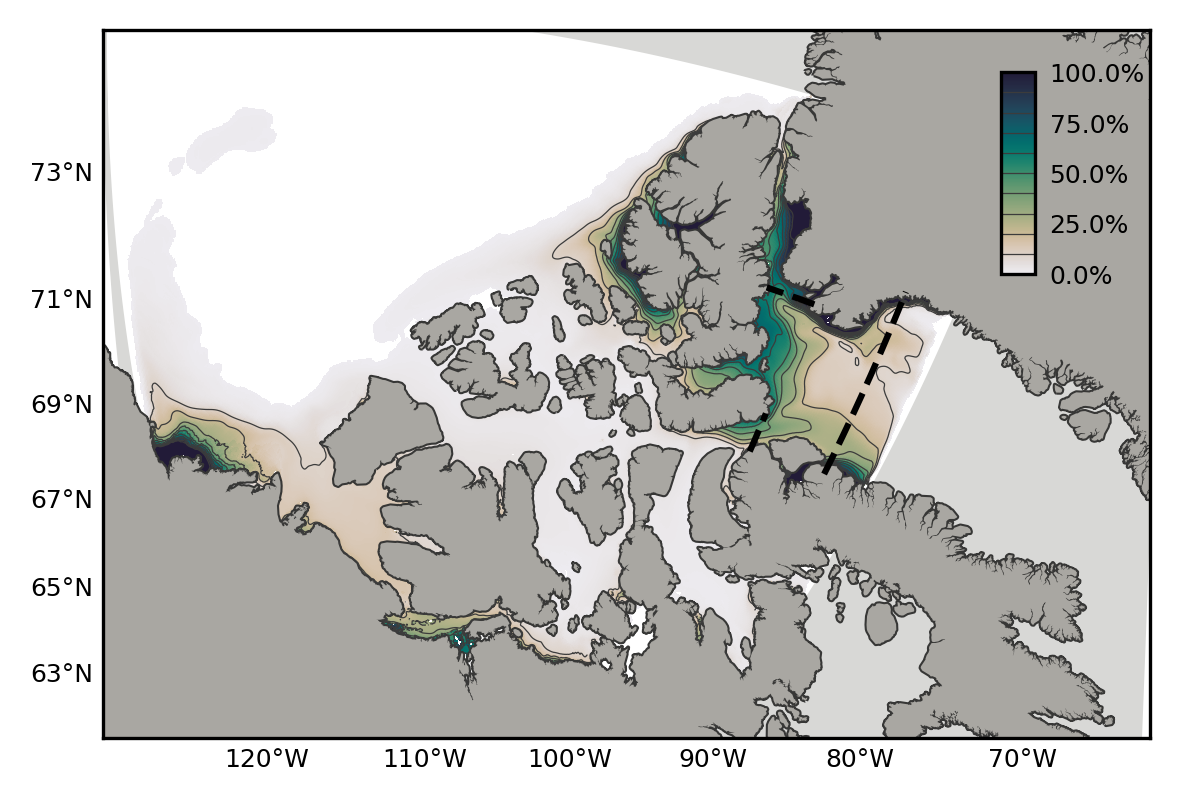

In [18]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/rivers-CAA.pickle','rb'))

#---------------------
x_model, y_model   = proj1(lon_sub, lat_sub)
x_ANHA12, y_ANHA12 = proj1(lon_ANHA12, lat_ANHA12)

CS1 = proj1.pcolormesh(x_model, y_model, np.ma.mean(ma_seas[:,:,:], axis=0), vmin=0, vmax=100, cmap=cmocean.cm.rain)

# Contour lines:
cmap_levels = [10,20,30,40,50,60,70,80,90,100]
seas = proj1.contour(x_model, y_model, np.ma.mean(ma_seas[:,:,:], axis=0), levels=cmap_levels, colors='#3c3c3c', linewidths=0.3)

# Draw flux boundary:
proj1.plot(x_model[P1i, P1j], y_model[P1i, P1j], '--k', linewidth=1.5)
proj1.plot(x_model[r1i, r1j], y_model[r1i, r1j], '--k', linewidth=1.5)
proj1.plot(x_model[N1i, N1j], y_model[N1i, N1j], '--k', linewidth=1.5)

# Draw domain boundaries:
# consider adding plus rimwidth of boundary 
ax1.fill_between(x_ANHA12[imin,:], y_ANHA12[imin,:], y_ANHA12[0,:], color='#d8d8d6')
ax1.fill_between(x_ANHA12[:,jmax], y_ANHA12[:,jmax], y_ANHA12[:,-1], color='#d8d8d6')
ax1.fill_between(x_ANHA12[imax,:], y_ANHA12[imax,:], y_ANHA12[-1,:], color='#d8d8d6')

# Colorbars:
cbaxes1 = fig.add_axes([0.79, 0.60, 0.025, 0.18])  
CBar1   = plt.colorbar(CS1, ax=ax1, cax=cbaxes1, ticks=np.arange(0,125,25))
CBar1.add_lines(seas)
CBar1.ax.tick_params(axis='y', length=0, labelsize=6)
CBar1.ax.set_yticklabels([f'{i:.1f}%' for i in CBar1.get_ticks()]);

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R3-mean-field.png', bbox_inches='tight', dpi=300)

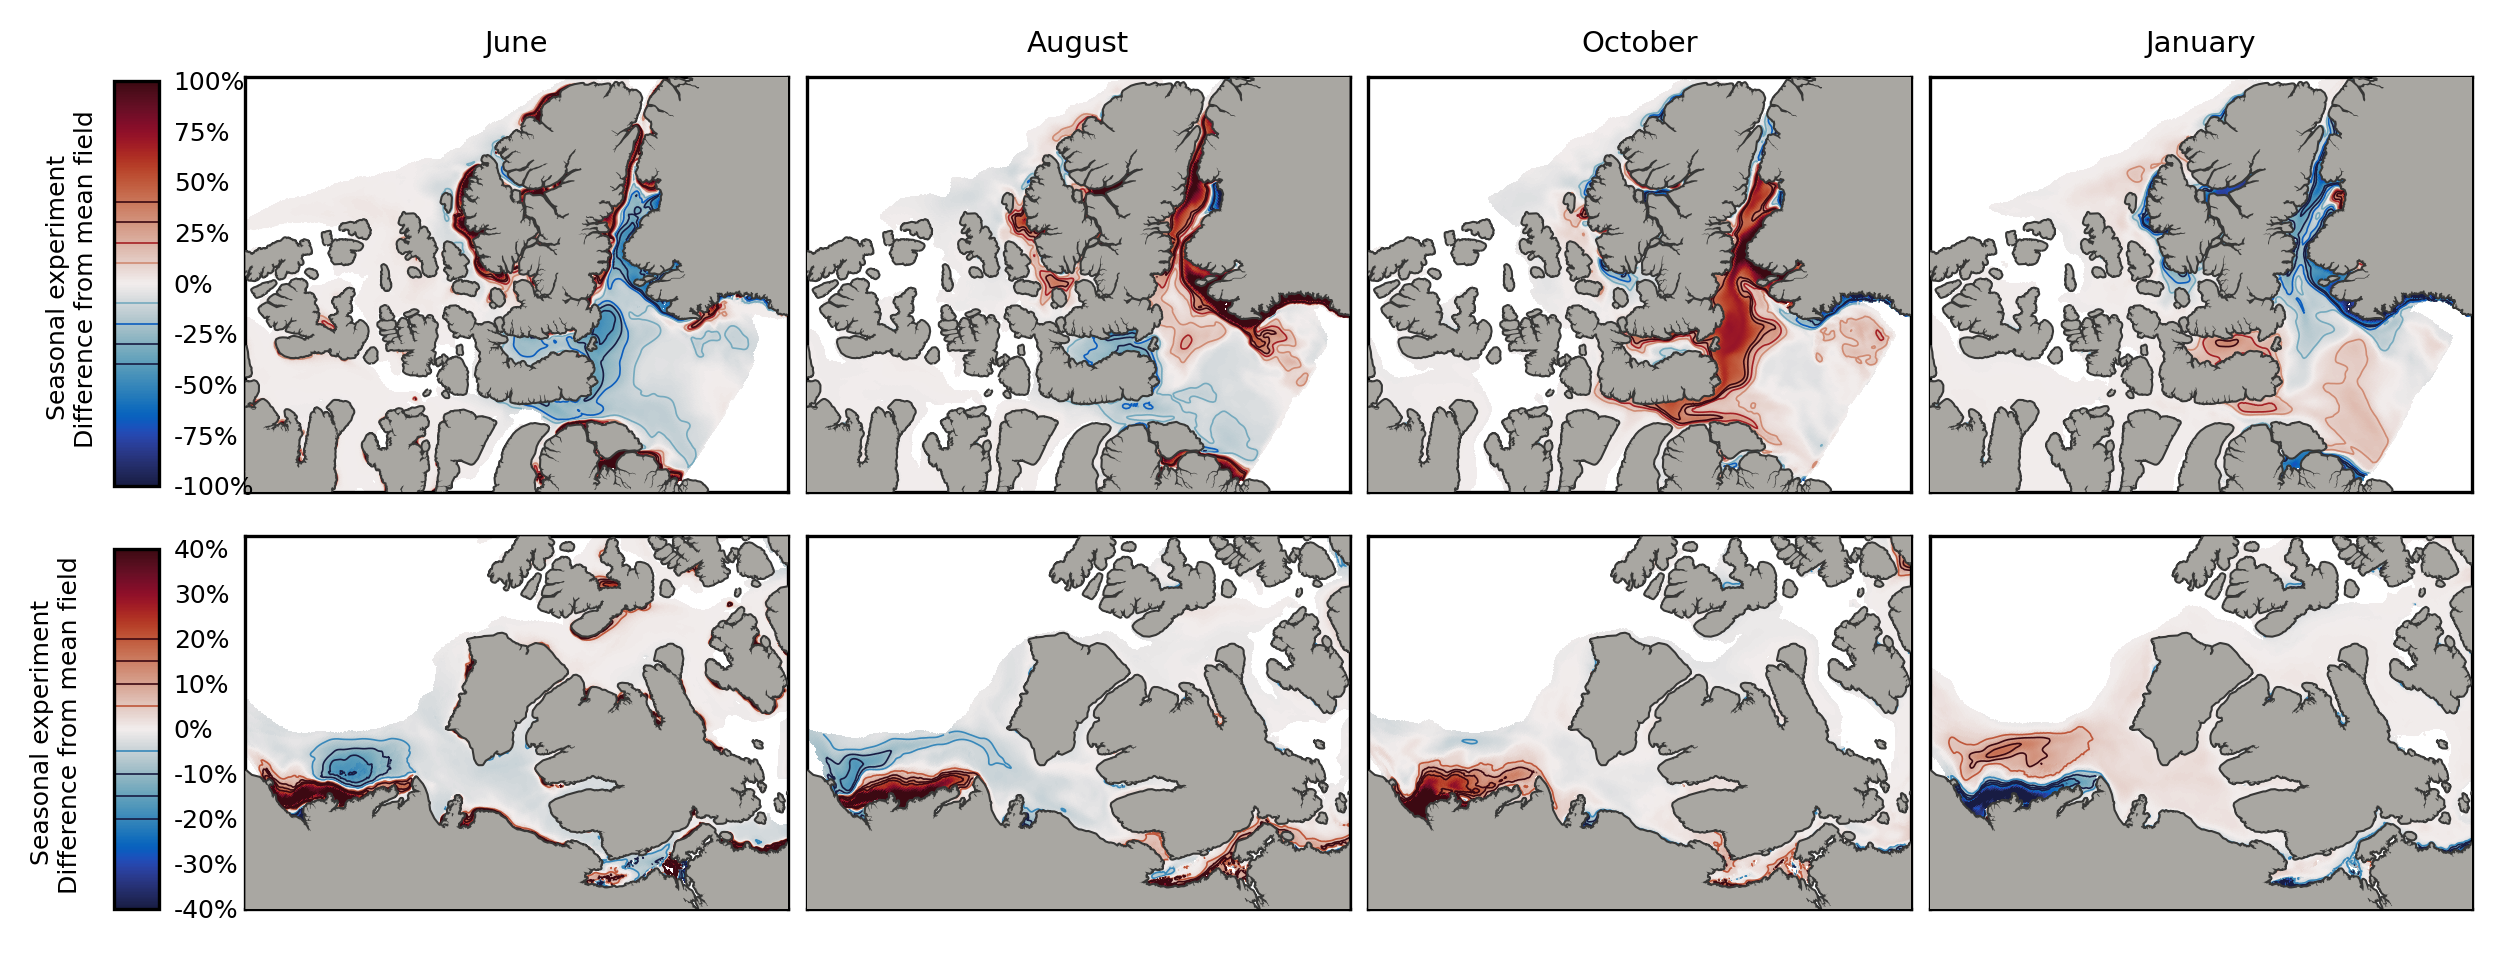

In [25]:
fig, ax, proj1, proj2 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/rivers-seasonal.pickle','rb'))

#---------------------
x_model1, y_model1 = proj1(lon_sub, lat_sub)
x_model2, y_model2 = proj2(lon_sub, lat_sub)

# Contour lines:
seas_levels1 = np.arange(-40, 50, 10)
seas_levels2 = np.arange(-20, 25, 5)

months=[5,7,9,0]
titles=['June','August','October','January']

top = 100
for m,axis in enumerate(ax[0,:].ravel()):    
    CS1 = proj1.pcolormesh(x_model1, y_model1, ma_seas[months[m],:,:]-np.ma.mean(ma_seas[:,:,:], axis=0), \
                           vmin=-top, vmax=top, cmap=cmocean.cm.balance, ax=axis)
    seas1 = proj1.contour(x_model1, y_model1, ma_seas[months[m],:,:]-np.ma.mean(ma_seas[:,:,:], axis=0), \
                         levels=seas_levels1, vmin=-30, vmax=30, cmap=cmocean.cm.balance, linewidths=0.4, ax=axis)
    axis.set_title(titles[m], fontsize=7)
    
top = 40
for m,axis in enumerate(ax[1,:].ravel()):    
    CS2 = proj2.pcolormesh(x_model2, y_model2, ma_seas[months[m],:,:]-np.ma.mean(ma_seas[:,:,:], axis=0), \
                           vmin=-top, vmax=top, cmap=cmocean.cm.balance, ax=axis)
    seas2 = proj2.contour(x_model2, y_model2, ma_seas[months[m],:,:]-np.ma.mean(ma_seas[:,:,:], axis=0), \
                         levels=seas_levels2, vmin=-10, vmax=10, cmap=cmocean.cm.balance, linewidths=0.4, ax=axis)

# Colorbars:
cbaxes1 = fig.add_axes([-0.05, 0.52, 0.02, 0.45])  
CBar1   = plt.colorbar(CS1, ax=ax[0,0], cax=cbaxes1, ticks=np.arange(-100,125,25))
CBar1.add_lines(seas1)
CBar1.set_label('Seasonal experiment \n Difference from mean field', labelpad=-50, fontsize=6)
CBar1.ax.tick_params(axis='y', length=0, labelsize=6)
CBar1.ax.set_yticklabels([f'{i:.0f}%' for i in CBar1.get_ticks()]);

cbaxes2 = fig.add_axes([-0.05, 0.05, 0.02, 0.40]) 
CBar2   = plt.colorbar(CS2, ax=ax[1,0], cax=cbaxes2, ticks=np.arange(-40,50,10)) 
CBar2.add_lines(seas2)
CBar2.set_label('Seasonal experiment \n Difference from mean field', labelpad=-50, fontsize=6)
CBar2.ax.tick_params(axis='y', length=0, labelsize=6)
CBar2.ax.set_yticklabels([f'{i:.0f}%' for i in CBar2.get_ticks()]);

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R3-seasonal-variation.png', bbox_inches='tight', dpi=300)